<a href="https://colab.research.google.com/github/tanyaoley/colab/blob/master/02_02_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.2 Кластеризация. Баннеры.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

## Центры кластеров (6 баллов)

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare. Полный датасет доступен здесь: https://archive.org/details/201309_foursquare_dataset_umn. Но в `../../data/checkins.csv.gz` я подготовил данные и оставил только 100000 элементов, иначе бы KMeans обучался пол дня.

Найдем на Google Maps координаты офисов компании:

```
33.751277, -118.188740 (Los Angeles)
25.867736, -80.324116 (Miami)
51.503016, -0.075479 (London)
52.378894, 4.885084 (Amsterdam)
39.366487, 117.036146 (Beijing)
-33.868457, 151.205134 (Sydney)
```

###  2.0 Read data (0.5 балла): 
**Загрузите датасет используя pandas `checkins.csv.gz`. Выведите его размер, первые 5 строк таблицы, статистическиую сводку(describe) **

In [72]:
import pandas as pd
colab = True
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')
    df = pd.read_csv('/content/drive/My Drive/Data/checkins.csv.gz')
else:
  df = pd.read_csv("../../data/checkins.csv.gz")
print(df.head())
df.describe()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
    latitude   longitude
0  38.895112  -77.036366
1  33.800745  -84.410520
2  45.523452 -122.676207
3  40.764462 -111.904565
4  33.448377 -112.074037


,latitude,longitude
count,100000.000000,100000.000000
mean,36.886388,-89.396849
std,8.351517,35.579317
min,-45.031162,-159.670833
25%,33.494170,-112.074037
50%,38.646991,-87.743938
75%,40.740389,-75.163789
max,67.631479,174.908056


###  2.1 MeanShift (1 балл): 
Для данной задачи мы не знаем сколько кластеров вообще существует, и есть ли они, поэтому воспользуемся методом, который сам находит нужное количество кластеров. Используйте `MeanShift`, указав `bandwidth=0.1`, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах. Документацию по нему вы можете найти в документации SKlearn [тут](http://scikit-learn.org/stable/modules/clustering.html#mean-shift).

**Обучите кластеризатор на всех данных.** Выполнение в 4 потока на i5 заняло 2 минуты.

In [73]:
from sklearn.cluster import MeanShift 
ms = MeanShift(bandwidth=0.1)
ms.fit(df)



MeanShift(bandwidth=0.1, bin_seeding=False, cluster_all=True, min_bin_freq=1,
          n_jobs=None, seeds=None)

### 2.2 Visualization (0.5 балла): 
**Визуализируйте с помощью matplotlib все точки из датасета** так, чтобы они были разукрашены в соответсвии с кластером к которому они принадлежат. **Добавьте на ваш график ещё точки расположений офисов**, сделайте их большими и красными, чтобы было видно. Рисовать каким-то образом карту мира под точками НЕ надо.

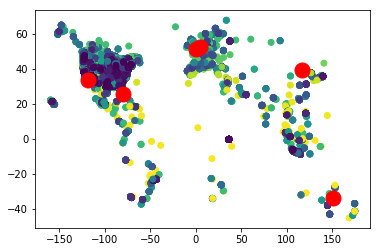

In [75]:
import numpy as np 
labels = ms.labels_
cluster_centers = ms.cluster_centers_


import matplotlib.pyplot as plt


plt.scatter(df.iloc[ :,1], df.iloc[:, 0], c=labels.astype(float))


data = np.array([[33.751277, -118.188740], 
[25.867736, -80.324116], 
[51.503016, -0.075479], 
[52.378894, 4.885084], 
[39.366487, 117.036146], 
[-33.868457, 151.205134]],dtype=np.float)

df1 = pd.DataFrame(data)
plt.plot(df1.iloc[:,1], df1.iloc[:,0], 'o', c = 'r', markersize=15)

###  2.3 Filter clusters (2 балла): 
Как видим на графике, некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения. 

**Выведите количество кластеров, которое удовлетворяет этому условию.**

**Hint**: `itertools.groupby`

In [76]:
from itertools import groupby
d = { i : len(list(j)) for i,j in groupby(sorted(labels))}
d = dict((k, v) for k, v in d.items() if v > 15)
len(d)


592

###  Задание 2.4 (2 балла): 
Как мы помним, необходимо разместить только 20 баннеров близ офисов компании. Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

**Выведите эти 20 центров кластеров, отсортрованных по возрастанию расстояния до ближайшего офиса.**

**Hint:** Для вычисления расстояния вы можете использовать обычную евклидову метрику и предполагать, что земля плоская. А можете использовать `geopy.distance.vincenty` если поймёте как.

In [80]:
import itertools  
from geopy.distance import vincenty
distance = dict()

for i in range(cluster_centers.shape[0]):
  if i in d:
    min_local = 0
    for j in range(df1.shape[0]):
      min_curr = vincenty((cluster_centers[i,0],cluster_centers[i,1]), (df1.iloc[j,0],df1.iloc[j,1])).kilometers
      if (min_local == 0) or (min_local>min_curr):
        min_local = min_curr
        point_cluster = (cluster_centers[i,0],cluster_centers[i,1])
    distance[min_local] = point_cluster  
l = (list(distance.keys()))
l.sort()
closest = [distance[l[i]] for i in range(20)]
closest

[(52.37296399032261, 4.892317222580647),
 (-33.86063042857143, 151.20477592857145),
 (25.8456722642857, -80.31889059642857),
 (51.502991260887086, -0.12553728870967767),
 (33.8098779552631, -118.14892380690813),
 (25.7858124199675, -80.2179380368254),
 (25.705349721052592, -80.28342873815798),
 (33.8883253427586, -118.04892817172427),
 (26.010098249285683, -80.19999058571432),
 (33.87298601157018, -118.36209114655645),
 (33.97257482142858, -118.16837066666663),
 (33.81730643390889, -117.891249170958),
 (26.138843786842077, -80.33434683684207),
 (33.98393587403844, -118.00740497307689),
 (33.67430265976576, -117.85878926777275),
 (26.120862658633104, -80.1589066802157),
 (34.06039755458241, -118.24870902659876),
 (26.20058464102565, -80.250716125641),
 (34.03548695312116, -118.43899771946148),
 (33.65089599288026, -117.75207397281613)]

Координата центра кластера ближайшего к какому-то из офисов компании должны быть `(52.37296399032261, 4.8923172225806466)`. Если у вас не так, то считайте, что вы сделали что-то неправильно. 